In [2]:
import matlab.engine
import numpy as np
import pandas as pd
import os

from scipy import optimize
import sklearn.gaussian_process as skg
from scipy.special import erf, erfc
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn import svm
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit

import bokeh.io 
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.transform import linear_cmap
from bokeh.models import LinearColorMapper
bokeh.io.output_notebook()
plt.ioff()

Loading BokehJS ...

# Define GPA params and visualization function

In [3]:
lam = 1e-2
l = 0.5
kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(l, length_scale_bounds="fixed")
gpa = skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)

In [303]:
def viz_gpa(gpa,thresh=False, contour=False, return_contour=False, return_thresh=False):

    x1range = [-1,1]
    x2range = [-1,1]
    dx = 0.01
    alpha = 0.5

    nx1 = int(np.diff(x1range)[0]/dx)
    nx2 = int(np.diff(x2range)[0]/dx)
    
    p = figure(
        x_range=[-1,1],
        y_range=[-1,1],
        match_aspect=True,
        plot_width=600,
        plot_height=600,
    )

    X1grid,X2grid = np.meshgrid(np.arange(*x1range,dx),np.arange(*x2range,dx))
    Xs = np.vstack([X1grid.ravel(), X2grid.ravel()]).transpose()
    # Xs = np.hstack((Xs, np.ones((Xs.shape[0],1))*alpha))

    # print(Xs)

    ys = gpa.predict(Xs).flatten()

    ys = ys.reshape(nx2,nx1)

    # print(ys)

    color_mapper = LinearColorMapper(palette='Viridis256', low=-1, high=2)

    if thresh:
        p.image(
            image=[(ys>0).astype(int)],
            x=x1range[0],
            y=x2range[0],
            dw=np.diff(x1range)[0],
            dh=np.diff(x2range)[0],
            color_mapper = color_mapper
        )
    else:
        p.image(
            image=[ys],
            x=x1range[0],
            y=x2range[0],
            dw=np.diff(x1range)[0],
            dh=np.diff(x2range)[0],
            palette='Viridis256'
        )
    if contour:
        plt.ioff()
        c = plt.contour(ys,[0])
        contsegs = c.allsegs[0]
        for cs in contsegs:
            p.line(
                x=cs[:,0]*dx+x1range[0],
                y=cs[:,1]*dx+x2range[0],
                line_width=3,
                color="black"
            )
        # print(contour)
    
    if contour and return_contour:
        return [[cs[:,0]*dx+x1range[0], cs[:,1]*dx+x2range[0]] for cs in contsegs]
    elif return_thresh:
        return (ys>0).astype(int)
    else:
        return p

# Define ground truth function

In [304]:
# def truth(x):
#     x = np.array(x)
#     r = np.linalg.norm(x,axis=1)
#     t = 0.25-np.abs(r-0.5)
#     # t += 0.1*(x[:,0] + x[:,1])
#     return t

# def truth(x):
#     x = np.array(x)
#     t = 0.1*(x[:,0] + x[:,1])
#     return t

# def truth(x):
#     x = np.array(x)
#     z = x[:,0]+x[:,1]
#     w = x[:,0]-x[:,1]
#     t = z+0.8-0.3*np.sin(5*w)
#     return t

def truth(x):
    x = np.array(x)
    t = x[:,1]+0.3-0.25*np.sin(7*x[:,0])
    return t


In [305]:
x0 = -1
dx = 0.01

x1 = np.arange(-1,1,dx)
x2 = np.copy(x1)
X1,X2 = np.meshgrid(x1,x2)

X = np.hstack((
    X1.reshape((-1,1)),
    X2.reshape((-1,1))
))

y = truth(X)
w = int(np.sqrt(len(y)))
y = y.reshape((w,w))
y_gt = y

In [306]:
c = plt.contour(y,[0])
contsegs = c.allsegs[0]

c_gt = [[cs[:,0]*dx+x0, cs[:,1]*dx+x0] for cs in contsegs]
# c_gt = [
#     contsegs[:,0]*dx+x0,
#     contsegs[:,1]*dx+x0
# ]

In [307]:
p = figure(
    x_range=[-1,1],
    y_range=[-1,1],
    match_aspect=True,
    plot_width=400,
    plot_height=400
)

color_mapper = LinearColorMapper(palette='Viridis256', low=-0.5, high=0.25)

p.image(
    image=[y],
    x=-1,
    y=-1,
    dw=2,
    dh=2,
    color_mapper = color_mapper
)

for c in c_gt:
    p.line(
        x=c[0],
        y=c[1],
        line_color="black",
        line_width=3
    )

show(p)

# Uniform Random

In [308]:
gpa_ur=skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)

n0 = 25
x0 = np.random.uniform(-1,1,(n0,1))
y0 = np.random.uniform(-1,1,(n0,1))

X = np.hstack((x0,y0))
y = np.array([truth([x]) for x in X]).reshape(-1,1)
# print(y)
gpa_ur.fit(X,y)

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=0.5))

In [309]:
p=viz_gpa(gpa_ur,thresh=False, contour=True)
p.circle(
    gpa_ur.X_train_[:,0],
    gpa_ur.X_train_[:,1],
    color="black"
)
show(p)

In [310]:
c_ur = viz_gpa(gpa_ur,thresh=False, contour=True, return_contour=True)

# Grid Search

In [311]:
gpa_gs=skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)

n0 = 100
nn = int(np.sqrt(n0))

xx = np.arange(0,2,2/nn)-1+1/nn
yy = np.arange(0,2,2/nn)-1+1/nn

x0,y0=np.meshgrid(xx,yy)
x0=x0.reshape([-1,1])
y0=y0.reshape([-1,1])

# x0 = np.random.uniform(-1,1,(n0,1))
# y0 = np.random.uniform(-1,1,(n0,1))

X = np.hstack((x0,y0))
y = np.array([truth([x]) for x in X]).reshape(-1,1)
# print(y)
gpa_gs.fit(X,y)

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=0.5))

In [312]:
p=viz_gpa(gpa_gs,thresh=False, contour=True)
p.circle(
    gpa_gs.X_train_[:,0],
    gpa_gs.X_train_[:,1],
    color="black"
)
show(p)

# Uncertainty Minimization

In [313]:
def gpa_next(gpa,x,y):

    n = gpa.X_train_.shape[1]
    g = skg.GaussianProcessRegressor(
        alpha=1e-6,
        kernel=kernel
    )
    g.fit(
        np.vstack((gpa.X_train_, np.array(x).reshape(-1,n))),
        np.vstack((gpa.y_train_, np.array(y).reshape(-1,1)))
    )
    # print(g.X_train_)
    return g

In [314]:
def p_err(mu,sig):
    return 0.5 - erf(np.abs(mu)/(np.sqrt(2)*sig))

In [315]:
# Given a pair (x,y) of "next" data, return the posterior intagrated Perr
def p_err_next(gpa,x,y):
    
    g = gpa_next(gpa,[x],y)
    
    x1range=[-1,1] # x position
    x2range=[-1,1] # y position
    dx = 0.1

    nx1 = int(np.diff(x1range)[0]/dx)
    nx2 = int(np.diff(x2range)[0]/dx)

    X1grid,X2grid = np.meshgrid(np.arange(*x1range,dx),np.arange(*x2range,dx))
    Xs = np.vstack([X1grid.ravel(), X2grid.ravel()]).transpose()

    mus, stds = g.predict(Xs, return_std=True)
    mus = mus[:,0]
    p_err_tp1 = np.sum(p_err(mus,stds))
    
    return p_err_tp1

In [316]:
# Given only a "next" x, assume the sampled y will land exactly on the mean and then return the posterior Perr
@jit
def infer_next(x,args):
    
    gpa = args
    
    n = gpa.X_train_.shape[1]
    yi = gpa.predict(x.reshape(-1,n))
    
    p_err_inf = p_err_next(gpa,x,yi)
    
    return p_err_inf

In [317]:
gpa_di = skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)

# Generate random initial data
n0 = 5
x0 = np.random.uniform(-1,1,(n0,1))
y0 = np.random.uniform(-1,1,(n0,1))

X = np.hstack((x0,y0))
y = np.array([truth([x]) for x in X]).reshape(-1,1)
gpa_di.fit(X,y)

bounds = [
    [-1,1],
    [-1,1]
]

N = 95
regret_di=[]
for i in tqdm(range(N)):
    
    opt = optimize.differential_evolution(
        infer_next,
        bounds,
        args=[gpa_di]
    )
    
    x_next = opt.x
    y_next = truth([x_next])
    
    gpa_di = gpa_next(gpa_di,x_next,y_next)


  0%|                                                    | 0/95 [00:00<?, ?it/s]/tmp/ipykernel_5326/3791675807.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "infer_next" failed type inference due to: Untyped global name 'p_err_next': Cannot determine Numba type of <class 'function'>

File "../../../../../tmp/ipykernel_5326/3791675807.py", line 10:
<source missing, REPL/exec in use?>

  @jit
/home/kellan/anaconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "infer_next" was compiled in object mode without forceobj=True.

File "../../../../../tmp/ipykernel_5326/3791675807.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/kellan/anaconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is

In [318]:
p = viz_gpa(gpa_di,thresh=False, contour=True)
p.circle(
    gpa_di.X_train_[5:,0],
    gpa_di.X_train_[5:,1],
    color="black"
)
show(p)

In [319]:
c_di = viz_gpa(gpa_di,thresh=False, contour=True, return_contour=True)

# Single Comparison

In [320]:
c_ur = viz_gpa(gpa_ur,thresh=False, contour=True, return_contour=True)
c_gs = viz_gpa(gpa_gs,thresh=False, contour=True, return_contour=True)
c_di = viz_gpa(gpa_di,thresh=False, contour=True, return_contour=True)

In [321]:
p = figure(
    x_range=[-1,1],
    y_range=[-1,1],
    match_aspect=True,
    plot_width=400,
    plot_height=400
)

for c in c_gt:
    p.line(
        x=c[0],
        y=c[1],
        line_color="black",
        line_width=3
    )
    
for c in c_gs:
    p.line(
        x=c[0],
        y=c[1],
        line_color="red",
        line_width=3,
        legend_label="Grid Search"
    )
    
for c in c_di:
    p.line(
        x=c[0],
        y=c[1],
        line_color="blue",
        line_width=3,
        legend_label="Uncertainty Minimization"
    )

show(p)

# Rate Comparison

In [322]:
def solve_di(n_samples):

    gpa_di = skg.GaussianProcessRegressor(
        alpha=lam,
        kernel=kernel
    )

    # Generate random initial data
    n0 = 5
    x0 = np.random.uniform(-1,1,(n0,1))
    y0 = np.random.uniform(-1,1,(n0,1))

    X = np.hstack((x0,y0))
    y = np.array([truth([x]) for x in X]).reshape(-1,1)
    gpa_di.fit(X,y)

    bounds = [
        [-1,1],
        [-1,1]
    ]

    N = n_samples-5
    regret_di=[]
    for i in range(N):

        opt = optimize.differential_evolution(
            infer_next,
            bounds,
            args=[gpa_di]
        )

        x_next = opt.x
        y_next = truth([x_next])

        gpa_di = gpa_next(gpa_di,x_next,y_next)
        
    regret = np.sum(np.abs(viz_gpa(gpa_di,return_thresh=True)-(y_gt>=0)))
        
    return regret
        
        
def solve_gs(n_samples):
    
    gpa_gs=skg.GaussianProcessRegressor(
        alpha=lam,
        kernel=kernel
    )

    n0 = n_samples
    nn = int(np.sqrt(n0))

    xx = np.arange(0,2,2/nn)-1+1/nn
    yy = np.arange(0,2,2/nn)-1+1/nn

    x0,y0=np.meshgrid(xx,yy)
    x0=x0.reshape([-1,1])
    y0=y0.reshape([-1,1])

    # x0 = np.random.uniform(-1,1,(n0,1))
    # y0 = np.random.uniform(-1,1,(n0,1))

    X = np.hstack((x0,y0))
    y = np.array([truth([x]) for x in X]).reshape(-1,1)
    # print(y)
    gpa_gs.fit(X,y)
    
    regret = np.sum(np.abs(viz_gpa(gpa_gs,return_thresh=True)-(y_gt>=0)))
    
    return regret

In [323]:
err_di = []
for j in tqdm(range(10)):
    err_di.append([])
    for i in np.arange(3,11):
        n = i**2
        err_di[-1].append(solve_di(n))

100%|███████████████████████████████████████████| 10/10 [08:46<00:00, 52.61s/it]


In [324]:
err_gs = []
for i in np.arange(3,11):
    n = i**2
    err_gs.append(solve_gs(n))

In [325]:
err_di = np.array(err_di)

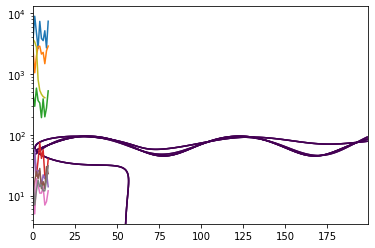

In [326]:
plt.semilogy(err_di)
plt.semilogy(err_gs)
plt.show()

In [327]:
df = pd.DataFrame(err_di)
df.to_csv("um_results4.csv")

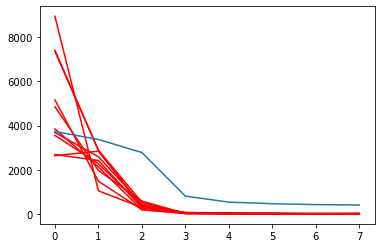

In [328]:
for err in err_di:
    plt.plot(err,c='r')
plt.plot(err_gs)
plt.show()

In [329]:
mu = np.mean(err_di,axis=0)
sig = np.std(err_di,axis=0)

In [330]:
NN=np.product(y_gt.shape)

In [331]:
x=np.arange(3,11)**2
plt.plot(x,mu/NN+sig/NN,c='b')
plt.plot(x,mu/NN-sig/NN,c='b')
plt.plot(x,err_gs/NN)

In [332]:
p = figure(
    x_range=[10,100],
    y_range=[0.00002,0.4],
    y_axis_type="log",
    plot_width=400,
    plot_height=300,
    x_axis_label="Number of Samples",
    y_axis_label="Error Rate"
)

x1=np.arange(3,11)**2
x2=x1[::-1]
y1=mu/NN+sig/NN
y2=(mu/NN-sig/NN)[::-1]
x = np.hstack((x1, x2))
y = np.hstack((y1, y2))

p.line(
    x=x1,
    y=mu/NN,
    line_width=3,
    legend_label="Uncertainty Minimization"
)

p.line(
    x=x1,
    y=err_gs/NN,
    color='red',
    line_width=3,
    legend_label="Grid Search"
)

p.patch(
    x=x,
    y=y,
    alpha=0.5
)

show(p)

In [333]:
x=np.arange(10)
y=x**2
p=figure(
    x_range=[0,10],
    y_range=[0.01,10**2],
    y_axis_type="log",

)
p.line(
    x=x,
    y=y
)
show(p)

# SVM Comparison

In [335]:
n0 = int(1e2)
nn = int(np.sqrt(n0))
nn=30

xx = np.arange(0,2,2/nn)-1+1/nn
yy = np.arange(0,2,2/nn)-1+1/nn

x0,y0=np.meshgrid(xx,yy)
x0=x0.reshape([-1,1])
y0=y0.reshape([-1,1])

X = np.hstack((x0,y0))
y = np.array([np.sign(truth([x])) for x in X]).reshape(-1)

In [336]:
clf=svm.SVC(kernel="rbf",C=1000.)
clf.fit(X,y)

SVC(C=1000.0)

In [337]:
dx = 0.01

x1 = np.arange(-1,1,dx)
x2 = np.copy(x1)
X1,X2 = np.meshgrid(x1,x2)

X = np.hstack((
    X1.reshape((-1,1)),
    X2.reshape((-1,1))
))

y_svm = clf.predict(X)
w = int(np.sqrt(len(y_svm)))
y_svm = y_svm.reshape((w,w))

In [338]:
p = figure(
    x_range=[-1,1],
    y_range=[-1,1],
    match_aspect=True,
    plot_width=400,
    plot_height=400
)

p.image(
    image=[y_svm],
    x=-1,
    y=-1,
    dw=2,
    dh=2,
    color_mapper = color_mapper
)

for c in c_gt:
    p.line(
        x=c[0],
        y=c[1],
        line_color="black",
        line_width=3
    )

show(p)

In [339]:
def solve_svm_gs(n_samples, C=100.):

    clf=svm.SVC(kernel="rbf",C=C)
    
    n0 = n_samples
    nn = int(np.sqrt(n0))

    xx = np.arange(0,2,2/nn)-1+1/nn
    yy = np.arange(0,2,2/nn)-1+1/nn

    x0,y0=np.meshgrid(xx,yy)
    x0=x0.reshape([-1,1])
    y0=y0.reshape([-1,1])

    X = np.hstack((x0,y0))
    y = np.sign(np.array([truth([x]) for x in X]).reshape(-1))
    
    clf.fit(X,y)
    
    dx = 0.01

    x1 = np.arange(-1,1,dx)
    x2 = np.copy(x1)
    X1,X2 = np.meshgrid(x1,x2)

    X = np.hstack((
        X1.reshape((-1,1)),
        X2.reshape((-1,1))
    ))

    y_svm = clf.predict(X)
    w = int(np.sqrt(len(y_svm)))
    y_svm = y_svm.reshape((w,w))
    y_svm = (y_svm+1)/2 # (-1,1)->(0,1)
    
    NN = np.product(y_svm.shape)
    
    plt.imshow(y_svm,origin='lower',extent=[-1,1,-1,1])
    plt.plot(c_gt[0][0],c_gt[0][1],c='k')
    plt.show()
    
    regret = np.sum(np.abs(y_svm-(y_gt>=0)))/NN
    
    return regret

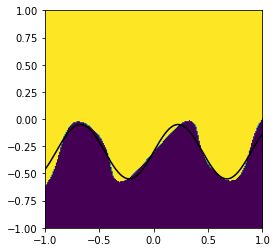

0.024125

In [345]:
solve_svm_gs(10**2, C=1000)

In [341]:
def solve_svm_ur(n_samples, C=100.):

    clf=svm.SVC(kernel="rbf",C=C)
    
    n0 = n_samples

    x0 = np.random.uniform(-1,1,(n0,1))
    y0 = np.random.uniform(-1,1,(n0,1))

    X = np.hstack((x0,y0))
    y = np.sign(np.array([truth([x]) for x in X]).reshape(-1))
    
    clf.fit(X,y)
    
    dx = 0.01

    x1 = np.arange(-1,1,dx)
    x2 = np.copy(x1)
    X1,X2 = np.meshgrid(x1,x2)

    X = np.hstack((
        X1.reshape((-1,1)),
        X2.reshape((-1,1))
    ))

    y_svm = clf.predict(X)
    w = int(np.sqrt(len(y_svm)))
    y_svm = y_svm.reshape((w,w))
    y_svm = (y_svm+1)/2 # (-1,1)->(0,1)
    
    NN = np.product(y_svm.shape)
    
    # plt.imshow(y_svm,origin='lower',extent=[-1,1,-1,1])
    # plt.plot(c_gt[0][0],c_gt[0][1])
    # plt.show()
    
    regret = np.sum(np.abs(y_svm-(y_gt>=0)))/NN
    
    return regret

In [347]:
err_svm = []
for i in tqdm(range(20)):
    err_svm.append([])
    for j in np.arange(3,11):
        n = j**2
        r = solve_svm_ur(n, C=500)
        err_svm[-1].append(r)

100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  9.14it/s]


In [350]:
mu_di = np.mean(err_di,axis=0)
sig_di = np.std(err_di,axis=0)

mu_svm = np.mean(err_svm,axis=0)
sig_svm = np.std(err_svm,axis=0)

In [352]:
print(mu_di)
print(sig_di)

[5013.8 2252.2  362.6   40.    24.1   19.6   12.7   15.9]
[2073.57125752  584.64276272  125.07693632   16.29110187   11.67433082
    6.28012739    5.64003546    6.1878914 ]


In [353]:
p = figure(
    x_range=[10,100],
    y_range=[0.00005,0.5],
    y_axis_type="log",
    plot_width=400,
    plot_height=300,
    x_axis_label="Number of Samples",
    y_axis_label="Error Rate"
)

x1=np.arange(3,11)**2
x2=x1[::-1]

y1=mu_di+sig_di
y2=(mu_di-sig_di)[::-1]
x_di = np.hstack((x1, x2))
y_di = np.hstack((y1, y2))

y1=mu_svm+sig_svm
y2=(mu_svm-sig_svm)[::-1]
x_svm = np.hstack((x1, x2))
y_svm = np.hstack((y1, y2))

# SVM
p.line(
    x=x1,
    y=mu_svm,
    color="green",
    line_width=3,
    legend_label="SVM"
)

p.patch(
    x=x_svm,
    y=y_svm,
    color='green',
    alpha=0.5
)

#Grid Search
p.line(
    x=x1,
    y=err_gs/NN,
    color='red',
    line_width=3,
    legend_label="GPR:Grid"
)

# Uncertainty Minimization
p.line(
    x=x1,
    y=mu_di/NN,
    line_width=3,
    legend_label="GPR:UM"
)

p.patch(
    x=x_di,
    y=y_di/NN,
    alpha=0.5
)

show(p)

# GPC Comparison

In [361]:
def solve_gpc_ur(n_samples):

    clf=skg.GaussianProcessClassifier(kernel=kernel)
    
    n0 = n_samples

    x0 = np.random.uniform(-1,1,(n0,1))
    y0 = np.random.uniform(-1,1,(n0,1))

    X = np.hstack((x0,y0))
    y = np.sign(np.array([truth([x]) for x in X]).reshape(-1))
    
    clf.fit(X,y)
    
    dx = 0.01

    x1 = np.arange(-1,1,dx)
    x2 = np.copy(x1)
    X1,X2 = np.meshgrid(x1,x2)

    X = np.hstack((
        X1.reshape((-1,1)),
        X2.reshape((-1,1))
    ))

    y_svm = clf.predict(X)
    w = int(np.sqrt(len(y_svm)))
    y_svm = y_svm.reshape((w,w))
    y_svm = (y_svm+1)/2 # (-1,1)->(0,1)
    
    NN = np.product(y_svm.shape)
    
    plt.imshow(y_svm,origin='lower',extent=[-1,1,-1,1])
    plt.plot(c_gt[0][0],c_gt[0][1])
    plt.show()
    
    regret = np.sum(np.abs(y_svm-(y_gt>=0)))/NN
    
    return regret

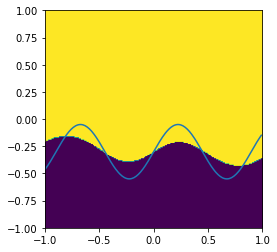

5.11e-02

In [364]:
solve_gpc_ur(5000)